In [1]:
from flowobjects import Gas, Liquid, Tank, FlowComponent, FluidNode, tube_kv, solve_network_pressures, plot_pressure_ladder, TubeComponent

e_ss = 1.5e-6

air = Gas(name="Air",R= 287, gamma = 1.4, viscosity=1.8e-5)
water = Liquid(name="Water", density = 1000, viscosity=0.001)
    
hp_tank = Tank(name='HP Tank', volume=3.78 * 0.001 * 2, pressure = 2e5, gas=air, gas_temp=300)
hp_tube_0 = TubeComponent(name='HP Bend 0 - SS-1610-9', D=0.01042, L=2, roughness=e_ss, bend_ang=0, K_extra=0)
orifice_0 = FlowComponent(name='Test Orifice', kv=3)
hp_tube_1 = TubeComponent(name='HP Bend 0 - SS-1610-9', D=0.01042, L=2, roughness=e_ss, bend_ang=45, K_extra=0.1)

hp_tank_node = FluidNode("HP Tank", tank=hp_tank, pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas)
tube0_to_orifice = FluidNode("Tube 0 to Orifice", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 
orifice_to_tube1 = FluidNode("Orifice to Tube 1", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 
atmosphere_node = FluidNode("Atmosphere", pressure=101325, constant_pressure=True, temperature=300, fluid=air)

hp_tank_node.connect_nodes([(tube0_to_orifice, hp_tube_0, False)])
tube0_to_orifice.connect_nodes([(hp_tank_node, hp_tube_0, True), (orifice_to_tube1, orifice_0, False)])
orifice_to_tube1.connect_nodes([(tube0_to_orifice, orifice_0, True), (atmosphere_node, hp_tube_1, False)])
atmosphere_node.connect_nodes([(orifice_to_tube1, hp_tube_1, True)])

total_nodes = [hp_tank_node, tube0_to_orifice, orifice_to_tube1, atmosphere_node]

for node in total_nodes:
    if node.tank:
        node.pressure = node.tank.pressure
        node.temperature = node.tank.gas_temp if node.tank.gas is not None else None

        if node.tank.liquid and node.tank.mass_liquid > 0:
            node.fluid = node.tank.liquid
        else:
            node.fluid = node.tank.gas

from tqdm import tqdm
# for _ in tqdm(range(1000)):
solve_network_pressures(total_nodes, 0)

plot_pressure_ladder(total_nodes)


ImportError: cannot import name 'plot_pressure_ladder' from 'flowobjects' (c:\Users\Martin\Active\FYPTurbine\flowobjects.py)

In [11]:
print(tube_kv(2e5, 199984, 2.322, 1.8e-5, D=0.01042, L=2, roughness=1.5e-6, bend_ang=0, K_extra=0))

1.0721243742766249


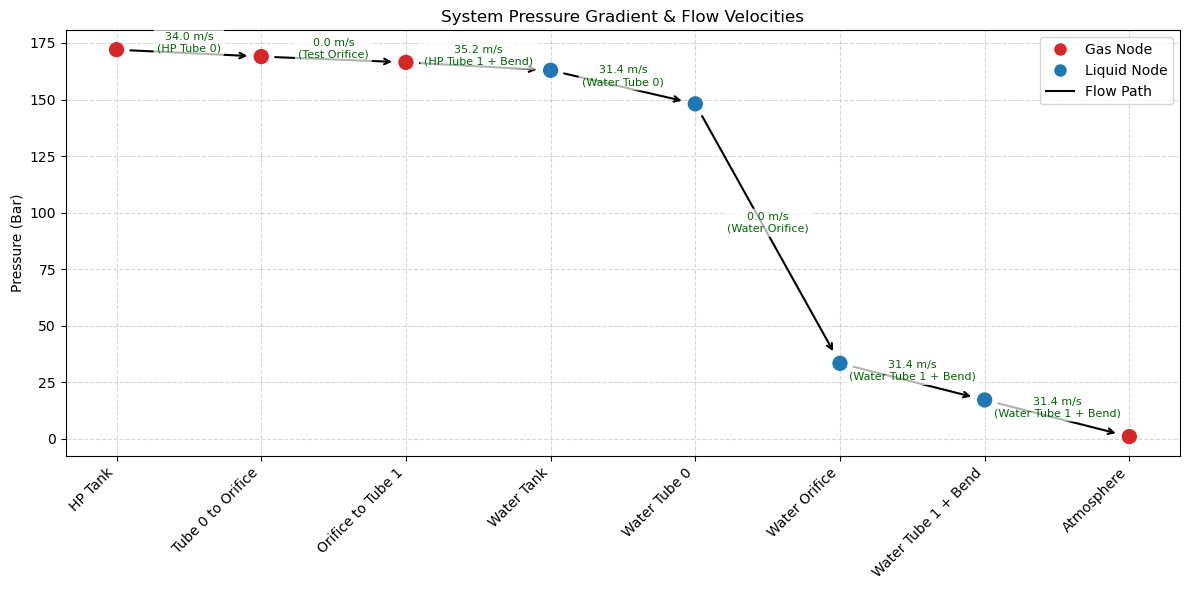

In [20]:
from flowobjects import Gas, Liquid, Tank, FlowComponent, FluidNode, plot_pressure_network, TubeComponent, dae_system, initialize_tanks, timed_valve_kv, regulator_kv

e_ss = 1.5e-6

air = Gas(name="Air",R= 287, gamma = 1.4, viscosity=1.8e-5)
water = Liquid(name="Water", density = 1000, viscosity=0.001)
    
hp_tank = Tank(name='HP Tank', volume=3.78 * 0.001 * 2, pressure = 200e5, gas=air, gas_temp=300)
hp_tube_0 = TubeComponent(name='HP Tube 0', D=0.01042, L=2, roughness=e_ss, bend_ang=0, K_extra=0)
orifice_0 = FlowComponent(name='Test Orifice', kv=3)
hp_tube_1 = TubeComponent(name='HP Tube 1 + Bend', D=0.01042, L=2, roughness=e_ss, bend_ang=45, K_extra=0.1)
water_tank = Tank(name='Water Tank', volume=0.005, mass_liquid=0.004*1000, pressure = 25e5, gas=air, gas_temp=300, liquid=water)
water_tube_0 = TubeComponent(name='Water Tube 0', D=0.01042, L=2, roughness=e_ss, bend_ang=0, K_extra=0)
water_orifice = FlowComponent(name='Water Orifice', kv=0.9)
water_tube_1= TubeComponent(name='Water Tube 1 + Bend', D=0.01042, L=2, roughness=e_ss, bend_ang=45, K_extra=0.1)

hp_tank_node = FluidNode("HP Tank", tank=hp_tank, pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas)
tube0_to_orifice = FluidNode("Tube 0 to Orifice", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 
orifice_to_tube1 = FluidNode("Orifice to Tube 1", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 

water_tank_node = FluidNode("Water Tank", tank=water_tank, pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)
water_tube_0_node = FluidNode("Water Tube 0", pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)
water_orifice_node = FluidNode("Water Orifice", pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)
water_tube_1_node = FluidNode("Water Tube 1 + Bend", pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)

atmosphere_node = FluidNode("Atmosphere", pressure=101325, constant_pressure=True, temperature=300, fluid=air)

hp_tank_node.connect_nodes([(tube0_to_orifice, hp_tube_0, False)])
tube0_to_orifice.connect_nodes([(hp_tank_node, hp_tube_0, True), (orifice_to_tube1, orifice_0, False)])
orifice_to_tube1.connect_nodes([(tube0_to_orifice, orifice_0, True), (water_tank_node, hp_tube_1, False)])
water_tank_node.connect_nodes([(orifice_to_tube1, hp_tube_1, True), (water_tube_0_node, water_tube_0, False)])
water_tube_0_node.connect_nodes([(water_tank_node, water_tube_0, True), (water_orifice_node, water_orifice, False)])
water_orifice_node.connect_nodes([(water_tube_0_node, water_orifice, True), (water_tube_1_node, water_tube_1, False)])
water_tube_1_node.connect_nodes([(water_orifice_node, water_tube_1, True), (atmosphere_node, water_tube_1, False)])
atmosphere_node.connect_nodes([(water_tube_1_node, water_tube_1, True)])

total_nodes = [hp_tank_node, tube0_to_orifice, orifice_to_tube1, water_tank_node, water_tube_0_node, water_orifice_node, water_tube_1_node, atmosphere_node]
tanks = [hp_tank, water_tank]

initial_masses, initial_temperatures = initialize_tanks(tanks)

# plot_pressure_network(total_nodes)


from scipy.integrate import solve_ivp
import numpy as np


solution = solve_ivp(
    dae_system,
    t_span=(0, 0.2),
    y0=initial_masses,
    method='RK45',
    rtol=1e-6,
    atol=1e-9,
    args=(total_nodes, tanks),
    # t_eval=np.linspace(0, 0.5, 5)
)

plot_pressure_network(total_nodes)


In [ ]:
from flowobjects import Gas, Liquid, Tank, FlowComponent, FluidNode, plot_pressure_network, TubeComponent, dae_system, initialize_tanks, timed_valve_kv, regulator_kv, nozzle_kv, create_series_nodes, reg_kv_simple

e_ss = 1.5e-6

air = Gas(name="Air",R= 287, gamma = 1.4, viscosity=1.8e-5)
water = Liquid(name="Water", density = 1000, viscosity=0.001)

# hp_tank_1 = Tank(name='HP Tank', volume=3.78 * 0.001, pressure = 100e5, gas=air, gas_temp=300)
# hp_bend_1 = TubeComponent(name='SS-810-2-8', D=0.01, L=0.05, roughness=e_ss, bend_ang=90)
# hp_tube_1 = TubeComponent(name='1/2" HP Tube 0.5m', D=0.01, L=0.5, roughness=e_ss)
# hp_bend_2 = TubeComponent(name='SS-810-2-8', D=0.01, L=0.05, roughness=e_ss, bend_ang=90)
# hp_tank_2 = Tank(name='HP Tank', volume=3.78 * 0.001, pressure = 100e5, gas=air, gas_temp=300)
# hp_tube_2 = TubeComponent(name='1" HP Tube 0.2m', D=0.022, L=0.2, roughness=e_ss)
# hp_bend_3 = TubeComponent(name='SS-1610-9', D=0.022, L=0.1, roughness=e_ss, bend_ang=90)
# hp_tube_3 = TubeComponent(name='1" HP Tube 0.5m', D=0.022, L=0.5, roughness=e_ss)
# # regulator = FlowComponent(name='Regulator', kv=lambda args: regulator_kv(args, 4e5, 1))
# regulator = FlowComponent(name='Regulator', kv=lambda args: reg_kv_simple(args, 4e5, 1.5))
# lp_tube_1 = TubeComponent(name='1" LP Tube 1m', D=0.022, L=1, roughness=e_ss)
# mani_bend = TubeComponent(name='Manifold Bend', D=0.022, L=0.1, roughness=e_ss, bend_ang=90)
# stator = FlowComponent(name='Stator', kv=nozzle_kv(23.73e-6))

# hp_tank_1_node = FluidNode("HP Tank 1", tank=hp_tank_1)
# hp_tank_2_node = FluidNode("HP Tank 2", tank=hp_tank_2)
# atmosphere_node = FluidNode("Atmosphere", pressure=101325, constant_pressure=True, temperature=300, fluid=air)

# nodes = [hp_tank_1_node] + create_series_nodes(hp_tank_1_node, [hp_bend_1, hp_tube_1, hp_bend_2], hp_tank_2_node) + [hp_tank_2_node] + create_series_nodes(hp_tank_2_node, [hp_tube_2, hp_bend_3, hp_tube_3, regulator, lp_tube_1, mani_bend, stator], atmosphere_node) + [atmosphere_node]
# tanks = [hp_tank_1, hp_tank_2]
# initial_masses, initial_temperatures = initialize_tanks(tanks)

hp_tank_1 = Tank(name='HP Tank', volume=3.78 * 0.001 * 2, pressure = 100e5, gas=air, gas_temp=300)
hp_tube_1 = TubeComponent(name='1" HP Tube 0.2m', D=0.022, L=0.2, roughness=e_ss)
hp_bend_1 = TubeComponent(name='SS-1610-9', D=0.022, L=0.1, roughness=e_ss, bend_ang=90)
hp_tube_2 = TubeComponent(name='1" HP Tube 0.5m', D=0.022, L=0.5, roughness=e_ss)
# regulator = FlowComponent(name='Regulator', kv=lambda args: regulator_kv(args, 4e5, 1))
regulator = FlowComponent(name='Regulator', kv=lambda args: reg_kv_simple(args, 4e5, 1.5, p_band=1e5))
lp_tube_1 = TubeComponent(name='1" LP Tube 1m', D=0.022, L=1, roughness=e_ss)
mani_bend = TubeComponent(name='Manifold Bend', D=0.022, L=0.1, roughness=e_ss, bend_ang=90)
stator = FlowComponent(name='Stator', kv=nozzle_kv(23.73e-6))

hp_tank_1_node = FluidNode("HP Tank 1", tank=hp_tank_1)
atmosphere_node = FluidNode("Atmosphere", pressure=101325, constant_pressure=True, temperature=300, fluid=air)

nodes = [hp_tank_1_node] + create_series_nodes(hp_tank_1_node, [hp_tube_1, hp_bend_1, hp_tube_2, regulator, lp_tube_1, mani_bend, stator], atmosphere_node) + [atmosphere_node]
for node in nodes:
    if node.pressure is None:
        node.pressure = 3e5
        node.temperature = 300.0
        # Assign a default fluid so density calculations don't fail immediately
        node.fluid = air
tanks = [hp_tank_1]
initial_masses, initial_temperatures = initialize_tanks(tanks)



# plot_pressure_network(total_nodes)

from scipy.integrate import solve_ivp
import numpy as np


def main():
    solution = solve_ivp(
        dae_system,
        t_span=(0, 3),
        y0=initial_masses,
        method='RK45',
        rtol=1e-6,
        atol=1e-9,
        args=(nodes, tanks),
        # t_eval=np.linspace(0, 0.5, 5)
    )

import cProfile
cProfile.run("main()", 'restats')
import pstats
p = pstats.Stats('restats')
p.sort_stats('cumulative').print_stats(40)

plot_pressure_network(nodes)


In [12]:
regulator_kv([0, 64.55e5, 1.04e5], 4e5, 1)

2.96

In [2]:
a = [1,2,3]
b = [4,5,6]
c = [7,8,9]
total_list = a + b + c
print(total_list)


[1, 2, 3, 4, 5, 6, 7, 8, 9]
